# Image classification with neural networks

<div class="alert alert-block alert-success">We will use CNN to solve this Image classification problem. 
    
In general, we prefer CNN for Image classification due to the following reasons:
    
 - **Efficient Parameter Usage:** CNNs reduce the need for excessive parameters in large images, making them computationally efficient and less prone to overfitting

 - **Spatial Pattern Recognition:** CNNs leverage local correlations in neighboring pixels to capture meaningful patterns and features in images

 - **Shift and Position Invariance:** CNNs are robust to shifts and variations in object positions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import glob

In [2]:
# Set the seed for reproducibility
torch.manual_seed(42)

<div class="alert alert-block alert-success"> We start off with the following steps :<br>

1. <strong>Load Dataset:</strong> Load EuroSAT_RGB dataset without normalization.

2. <strong>Calculate Stats:</strong> Efficiently compute mean and standard deviation in batches.

3. <strong>Normalize Data:</strong> Normalize images by subtracting mean and dividing by std. This normalization process ensures that the pixel values have a mean of approximately 0 and a standard deviation of approximately 1, which can improve model training.

4. <strong>Split for Training:</strong> Divide normalized dataset into 80% training and 20% testing.

5. <strong>Create Loaders:</strong> Build data loaders for batch processing in training and testing. Data loaders allow us to efficiently load and process data in batches during model training and evaluation.

In [4]:
import torch
from torch.utils.data import DataLoader, random_split

# Step 1: Load the dataset without normalization
data_transform_without_norm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
data_dir = 'EuroSAT_RGB'
dataset_without_norm = ImageFolder(root=data_dir, transform=data_transform_without_norm)

# Step 2: Compute mean and standard deviation
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in DataLoader(dataset_without_norm, batch_size=64, shuffle=False):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# Step 3: Use the computed mean and std for normalization
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = ImageFolder(root=data_dir, transform=data_transform)

# Rest of your code remains the same
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

<div class="alert alert-block alert-success">Now we go about defining the Neural Network architecture :

 - **Create the Custom Class:** The SatelliteImageClassifier class is created which inherits from nn.Module, to define the CNN architecture.

 - **Build Convolutional Layers:** The conv_layers sequential module is constructed, which incorporates three sets of convolutional layers that are followed by ReLU activations and max-pooling operations.

 - **Construct Fully Connected Layers:** The fc_layers sequential module is built, which comprises of two fully connected layers that employ ReLU activation functions. Additionally, a dropout layer is included for regularization purposes. The final layer generates class predictions.

 - **Forward Pass Definition:** The forward method executes convolutional and fully connected layers successively to generate predictions.

In [5]:
# Define the neural network architecture
class SatelliteImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SatelliteImageClassifier, self).__init__()
        
        # Convolutional layers: Extract features from images
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.ReLU(),                                              # Apply ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Perform max pooling
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # Second convolutional layer
            nn.ReLU(),                                              # Apply ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Perform max pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Third convolutional layer
            nn.ReLU(),                                              # Apply ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Perform max pooling
        )
        
        # Fully connected layers: Make final predictions
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),  # Fully connected layer with 512 output units
            nn.ReLU(),                   # Apply ReLU activation
            nn.Dropout(0.5),              # Apply dropout for regularization
            nn.Linear(512, num_classes), # Fully connected layer for class predictions
        )

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        
        # Flatten the convolutional layer output
        x = x.view(-1, 64 * 8 * 8)
        
        # Pass the flattened output through fully connected layers
        x = self.fc_layers(x)
        
        return x

<div class="alert alert-block alert-success">In the next step, we create the model. Note that we have 10 folders in our dataset so the number of classes is 10.

In [6]:
#Create the model
num_classes = len(dataset.classes)
model = SatelliteImageClassifier(num_classes)

<div class="alert alert-block alert-success"> Now we define our loss function and optimizer.
    
 - The cross-entropy loss quantifies the discrepancy between predicted probabilities and actual class labels which drives the model to improve its classification accuracy.

 - The optimizer leverages the model's parameters to optimize and update them during training, aiming to minimize the defined loss function and improve the model's performance.
    
 - We chose a learning rate of 0.001 as it is a commonly used starting point.

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<div class="alert alert-block alert-success">In this training loop, the model is trained for a set number of epochs (10 in this case). For each epoch, the model is put into training mode, and the loop iterates through batches of training data. Gradients are reset, predictions are made using the model, and the loss is calculated based on predicted outputs and actual labels. Backpropagation computes gradients, and the optimizer adjusts model parameters to minimize the loss. The cumulative loss for the epoch is tracked, and after each epoch, the average loss across batches is printed to monitor training progress.

In [9]:
# Train the model
num_epochs = 10  # Number of training epochs

# Loop through each epoch
for epoch in range(num_epochs):

    # Set the model to training mode
    model.train()

    # Initialize running loss for the current epoch
    running_loss = 0.0

    # Loop through batches in the training loader
    for inputs, labels in train_loader:

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: obtain model predictions
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        # Accumulate the loss for the current batch
        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/10, Loss: 0.9688384404196542
Epoch 2/10, Loss: 0.5952628262825972
Epoch 3/10, Loss: 0.47064186037468486
Epoch 4/10, Loss: 0.3750559288192783
Epoch 5/10, Loss: 0.3250428453616842
Epoch 6/10, Loss: 0.25755392160465024
Epoch 7/10, Loss: 0.21295554398079597
Epoch 8/10, Loss: 0.1859351163895349
Epoch 9/10, Loss: 0.16471596902026933
Epoch 10/10, Loss: 0.13335082557647537


<div class="alert alert-block alert-success">In this next code segment, the trained model is evaluated on a test dataset. The model is set to evaluation mode, and counters are initialized to track correct predictions and total samples. Within a loop through test batches, the model predicts labels and calculates accuracy by comparing predicted and true labels. The results are used to assess the model's performance on the test set. Furthermore, the precision, recall, and F1-score metrics are calculated using the stored predicted and true labels, giving a more comprehensive understanding of the model's performance across different classes.

In [10]:
# Evaluate the model on the test set
model.eval()  # Set the model in evaluation mode

# Initialize counters
correct = 0  # Counter for correctly predicted samples
total = 0    # Counter for total samples

# Initialize lists to store predicted and true labels
predicted_labels = []
true_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():

    # Loop through batches in the test loader
    for inputs, labels in test_loader:

        # Make predictions using the model
        outputs = model(inputs)
        
        # Find the predicted labels for each sample
        _, predicted = torch.max(outputs.data, 1)
        
        # Count the total number of samples in the batch
        total += labels.size(0)
        
        # Count correct predictions in the batch
        correct += (predicted == labels).sum().item()
        
        # Store predicted and true labels for the batch
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate overall test-set accuracy
accuracy = correct / total
print(f"Test-set Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Test-set Accuracy: 0.9109
Precision: 0.9110
Recall: 0.9109
F1-Score: 0.9100


<div class="alert alert-block alert-success">In the next step, we are generating and visualizing a confusion matrix based on the true labels and the predictions made by the model on the test set. This visual representation provides an intuitive way to quickly identify which classes the model is accurately predicting and where it's making errors.

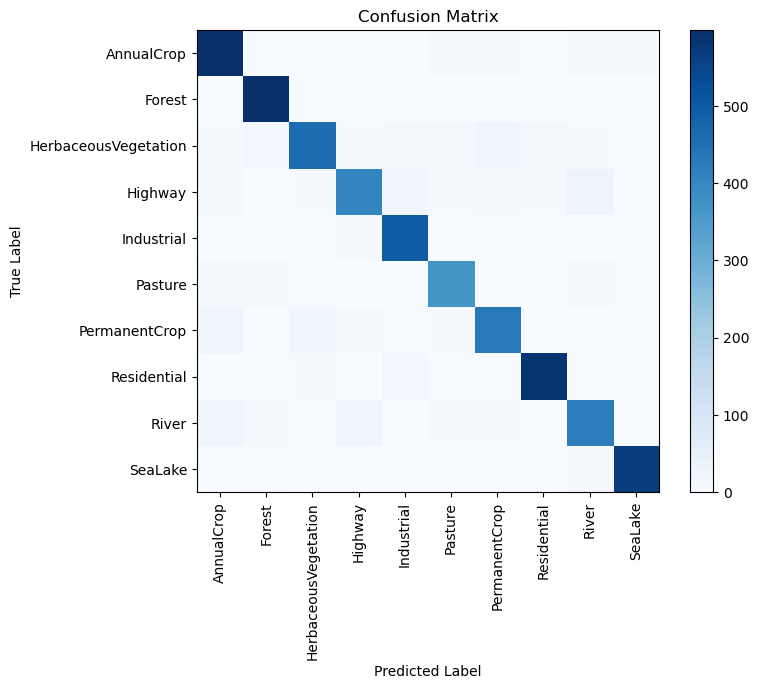

In [11]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(dataset.classes))
plt.xticks(tick_marks, dataset.classes, rotation=90)
plt.yticks(tick_marks, dataset.classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<div class="alert alert-block alert-success">In our final step, we visualize a selection of test dataset images and their labels in a 2x5 grid using matplotlib. For each image, we retrieve true and predicted class labels. 
Note that we are reshaping the image's dimensions from PyTorch format to Matplotlib format. This ensures proper visualization by rearranging the channels to the end.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

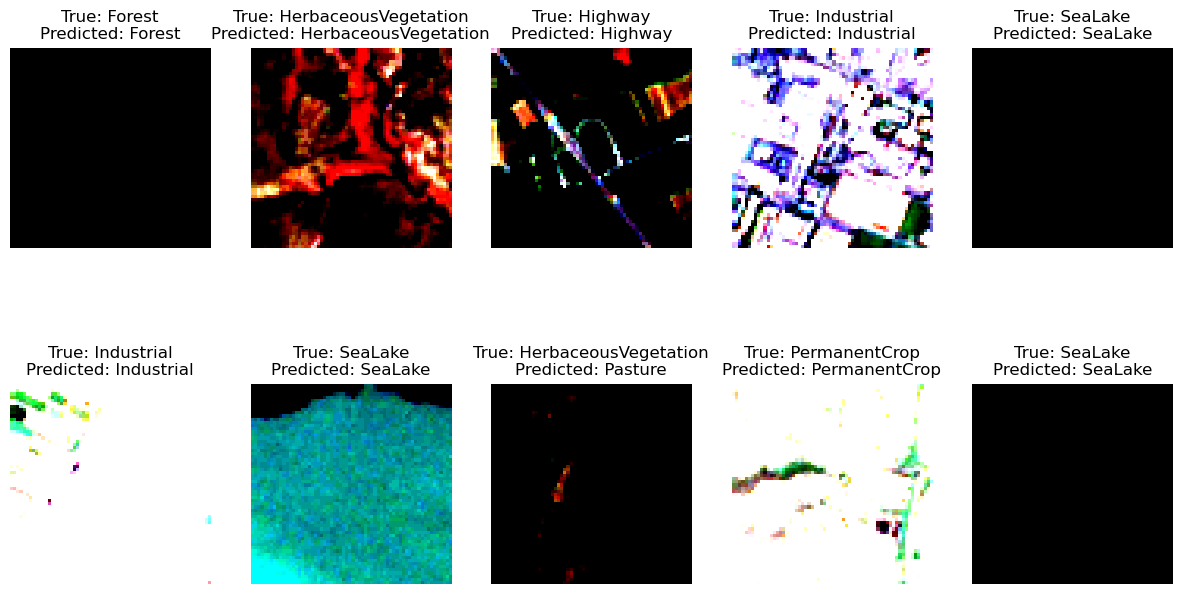

In [12]:
# Display some example images from the test set with their predicted classes
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ax in enumerate(axes.ravel()):
    img = np.transpose(test_dataset[i][0].numpy(), (1, 2, 0))
    true_class = dataset.classes[true_labels[i]]
    predicted_class = dataset.classes[predicted_labels[i]]
    ax.imshow(img)
    ax.set_title(f"True: {true_class}\nPredicted: {predicted_class}")
    ax.axis('off')